In [17]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define transformações para pré-processamento das imagens
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

In [3]:
# Carrega o dataset a partir do diretório 'images'
dataset = datasets.ImageFolder('./classes/', transform=transform)

In [4]:
# Divida o dataset em conjuntos de treinamento e teste
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
# Defina os dataloaders para carregar os dados
batch_size = 112
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# X_out = ((X_in - kernel_size + 2*padding) / stride) + 1
cae = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
    nn.BatchNorm2d(num_features=6),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0), 
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), # [64, 8, 8]
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0), 
     
    nn.ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=5, stride=2, padding=0),
    nn.BatchNorm2d(num_features=6),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=2, stride=3, padding=2),
    nn.Sigmoid()
)

x, _ = dataset[0]
x = cae(x.unsqueeze(0))
x.size()

torch.Size([1, 1, 28, 28])

In [7]:
# Definir modelo CAE
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Codificação
        x = self.encoder(x)
        
        # Decodificação
        x = self.decoder(x)
        
        return x

In [8]:
# Instanciar modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CAE()
model = model.to(device)

In [9]:
# Definir função de perda e otimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
# Treinar modelo
num_epochs = 500
for epoch in range(num_epochs):
    epoch_loss = []
    for batch in train_loader:
        feature, label = batch
        feature = feature.to(device)
        
        # Forward pass
        recon = model(feature)
        loss = criterion(recon, feature)
        epoch_loss.append(loss.detach().item())
        
        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss = np.array(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss.mean():.4f}")

# Salvando o modelo
torch.save(model.state_dict(), 'cae.pth')

Epoch [1/500], Loss: 0.0241
Epoch [2/500], Loss: 0.0150
Epoch [3/500], Loss: 0.0067
Epoch [4/500], Loss: 0.0052
Epoch [5/500], Loss: 0.0041
Epoch [6/500], Loss: 0.0035
Epoch [7/500], Loss: 0.0031
Epoch [8/500], Loss: 0.0027
Epoch [9/500], Loss: 0.0023
Epoch [10/500], Loss: 0.0021
Epoch [11/500], Loss: 0.0019
Epoch [12/500], Loss: 0.0017
Epoch [13/500], Loss: 0.0017
Epoch [14/500], Loss: 0.0015
Epoch [15/500], Loss: 0.0015
Epoch [16/500], Loss: 0.0014
Epoch [17/500], Loss: 0.0014
Epoch [18/500], Loss: 0.0013
Epoch [19/500], Loss: 0.0012
Epoch [20/500], Loss: 0.0012
Epoch [21/500], Loss: 0.0012
Epoch [22/500], Loss: 0.0011
Epoch [23/500], Loss: 0.0011
Epoch [24/500], Loss: 0.0011
Epoch [25/500], Loss: 0.0011
Epoch [26/500], Loss: 0.0011
Epoch [27/500], Loss: 0.0011
Epoch [28/500], Loss: 0.0010
Epoch [29/500], Loss: 0.0011
Epoch [30/500], Loss: 0.0010
Epoch [31/500], Loss: 0.0010
Epoch [32/500], Loss: 0.0010
Epoch [33/500], Loss: 0.0010
Epoch [34/500], Loss: 0.0010
Epoch [35/500], Loss: 0

In [11]:
# Carregando o modelo
model = CAE()
model.load_state_dict(torch.load('cae.pth'))
model = model.to(device)

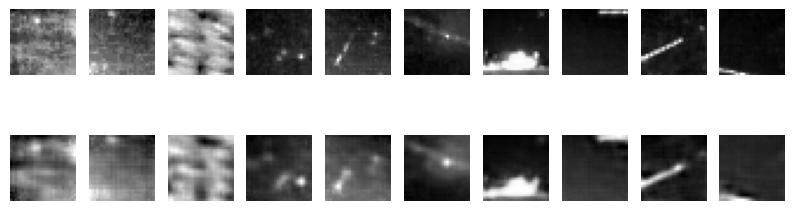

In [15]:
# Testar modelo
test_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.to(device)
        
        # Reconstruir imagem
        recon = model(img)
        
        img = img.cpu().detach().numpy()
        recon = recon.cpu().detach().numpy()
        
        # Exibir imagem original e reconstruída
        plt.figure(figsize=(10, 3))
        for i in range(10):
            # Imagem original
            plt.subplot(2, 10, i+1)
            plt.imshow(img[i, 0], cmap='gray')
            plt.axis('off')

            # Imagem reconstruída
            plt.subplot(2, 10, i+11)
            plt.imshow(recon[i, 0], cmap='gray')
            plt.axis('off')

        plt.show()
        break